In [8]:
!pip install datasets
!pip install torch
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk
!pip install transformers
!pip install tqdm
!pip install google-colab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [14]:
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, FreqDist
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Model construction
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
from tqdm.notebook import tqdm

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from sklearn.model_selection import train_test_split

#from google.colab import drive
#drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
dataset = load_dataset( "glue", "sst2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [16]:
dataset
# the dataset is already pre-split into train, test, and validation set
# consisting of the sentences, label, and the index

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [18]:
# Split the dataset into train, validation, and test set dataframes
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [19]:
# Since the data was just pulled lets look at the sentences
print(df_train[['sentence', 'label']].head())
# from here  we can see that the label consist of 0 and 1 so no further processing is needed
# for the label, 0 in this case is a negative sentiment and 1 indicates a positive sentiment

                                            sentence  label
0       hide new secretions from the parental units       0
1               contains no wit , only labored gags       0
2  that loves its characters and communicates som...      1
3  remains utterly satisfied to remain the same t...      0
4  on the worst revenge-of-the-nerds clichés the ...      0


In [20]:
# Looking at the distribution
label_distribution = df_train.label.value_counts()
label_distribution
# The dataset is slightly imbalanced, with more positive samples than negative

1    37569
0    29780
Name: label, dtype: int64

In [21]:
# With NLP the length of the text is important as the BERT model does have a token limit
# of 512 characters.

sent_length = df_train.sentence.apply(lambda x: len(x.split()))
sent_length.describe()

count    67349.000000
mean         9.409553
std          8.073806
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max         52.000000
Name: sentence, dtype: float64

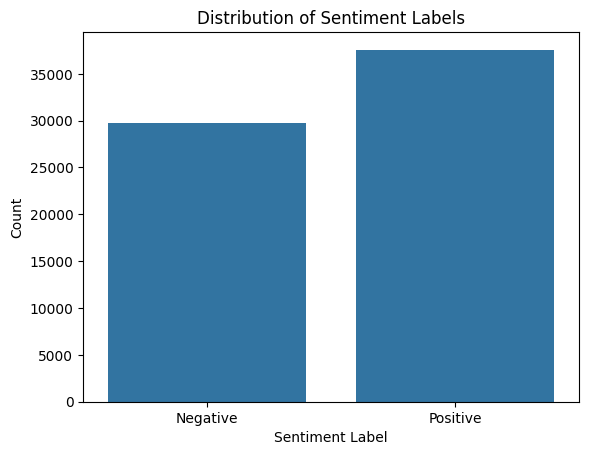

In [22]:
sns.countplot(x='label', data=df_train)

plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["Negative", "Positive"])

plt.show()


In [23]:
pos_sent = ' '.join(df_train[df_train['label']==1]['sentence'])
neg_sent = ' '.join(df_train[df_train['label']==0]['sentence'])

pos_cloud = wordcloud.WordCloud(background_color='white').generate(pos_sent)
neg_cloud = wordcloud.WordCloud(background_color='white').generate(neg_sent)

# the above code is used to create a wordcloud of the positive and negative sentiment

Text(0.5, 1.0, 'Negative Sentiment Word Cloud')

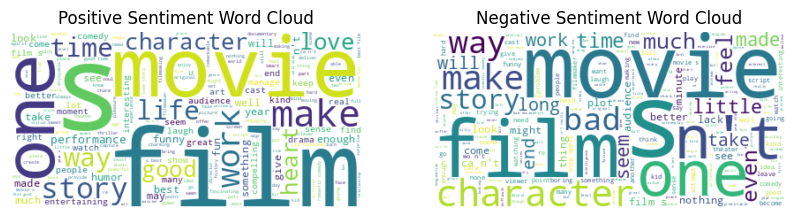

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')


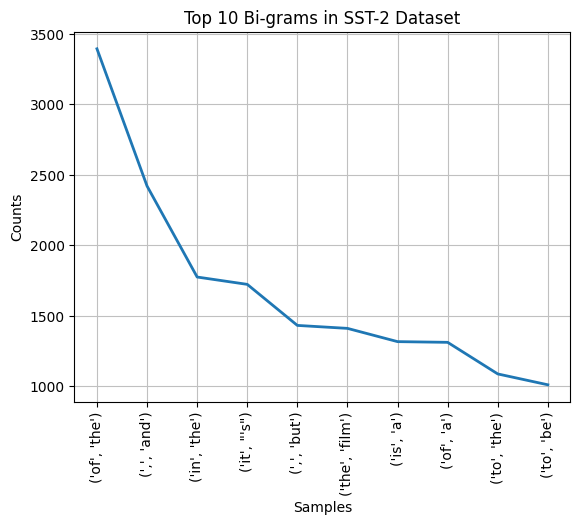

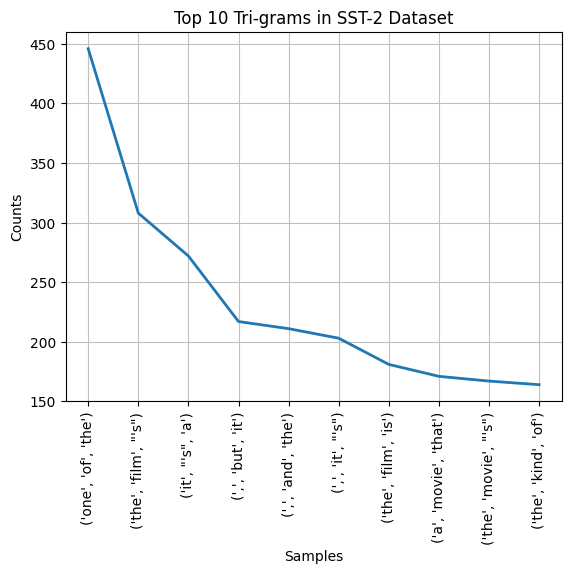

<Axes: title={'center': 'Top 10 Tri-grams in SST-2 Dataset'}, xlabel='Samples', ylabel='Counts'>

In [25]:
# Now we use nltk and punkd to extract the bigrams, trigrams, and ngrams
tokens = df_train['sentence'].apply(word_tokenize)

# Create bi-grams and tri-grams
bi_grams = tokens.apply(lambda x: list(bigrams(x)))
tri_grams = tokens.apply(lambda x: list(trigrams(x)))

# Flatten the list of bi-grams/tri-grams and get frequency distribution
bi_gram_freq = FreqDist([bg for sublist in bi_grams for bg in sublist])
tri_gram_freq = FreqDist([tg for sublist in tri_grams for tg in sublist])

# Plotting - showing top 10 for brevity
bi_gram_freq.plot(10, title='Top 10 Bi-grams in SST-2 Dataset')
tri_gram_freq.plot(10, title='Top 10 Tri-grams in SST-2 Dataset')

In [26]:
# Now attempt with word cloud and bi and trigrams with words remvoed.

stop_words = set(stopwords.words('english'))

def clean_sentence(sentence):
  tokens = word_tokenize(sentence)
  filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
  # should it be word.lower()?
  return filtered_tokens

df_train['cleaned_sentence'] = df_train['sentence'].apply(clean_sentence)


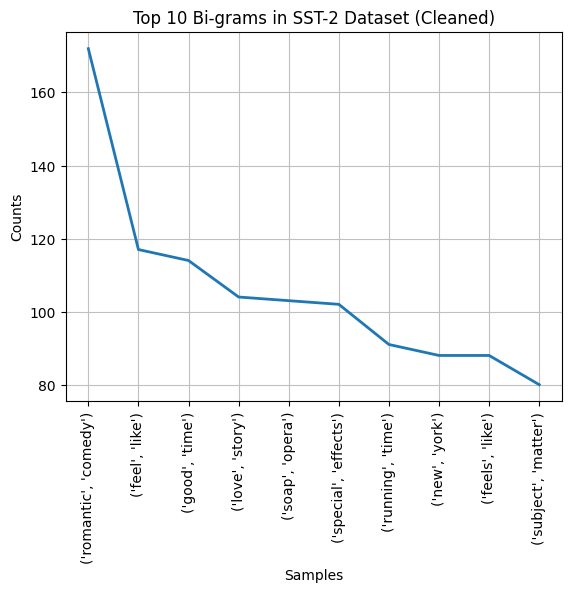

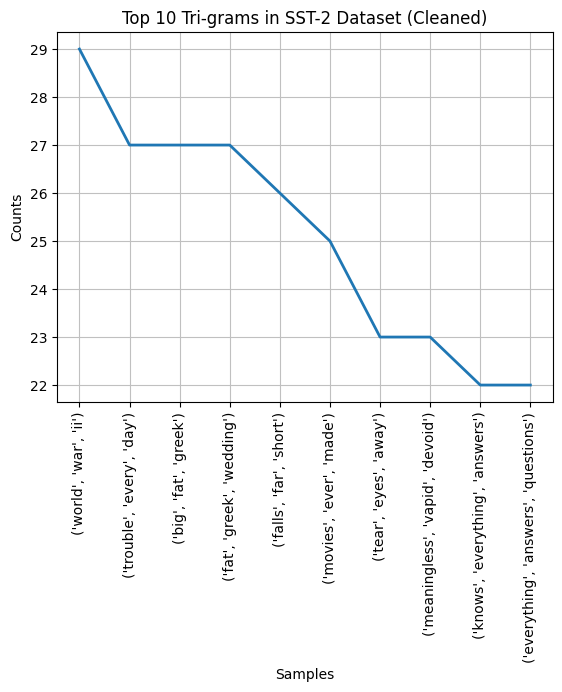

<Axes: title={'center': 'Top 10 Tri-grams in SST-2 Dataset (Cleaned)'}, xlabel='Samples', ylabel='Counts'>

In [27]:
bi_grams = df_train['cleaned_sentence'].apply(lambda x: list(bigrams(x)))
tri_grams = df_train['cleaned_sentence'].apply(lambda x: list(trigrams(x)))

bi_gram_freq = FreqDist([bg for sublist in bi_grams for bg in sublist])
tri_gram_freq = FreqDist([tg for sublist in tri_grams for tg in sublist])

bi_gram_freq.plot(10, title='Top 10 Bi-grams in SST-2 Dataset (Cleaned)')
tri_gram_freq.plot(10, title='Top 10 Tri-grams in SST-2 Dataset (Cleaned)')


(-0.5, 399.5, 199.5, -0.5)

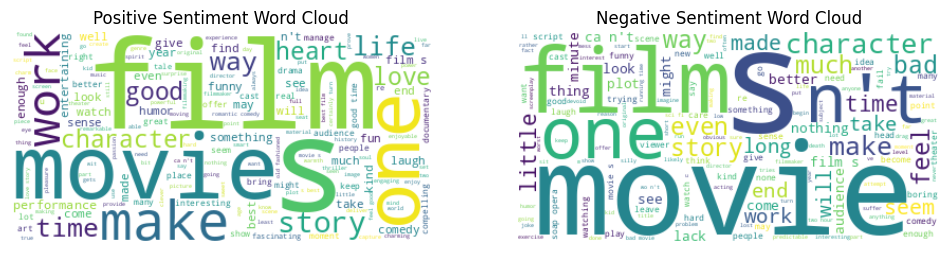

In [28]:
cleanpos_sent = ' '.join([' '.join(sentence) for sentence in df_train[df_train['label'] == 1]['cleaned_sentence']])
cleanneg_sent = ' '.join([' '.join(sentence) for sentence in df_train[df_train['label'] == 0]['cleaned_sentence']])

# Word cloud generation
pos_cloud = wordcloud.WordCloud(background_color='white').generate(pos_sent)
neg_cloud = wordcloud.WordCloud(background_color='white').generate(neg_sent)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')


In [29]:
# Split the original training data
train_sentences = dataset['train']['sentence']
train_labels = dataset['train']['label']

# Create a new train and test split
new_train_sentences, test_sentences, new_train_labels, test_labels = train_test_split(
    train_sentences, train_labels, test_size=0.1, random_state=42
)

In [30]:
# BERT may be to large

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(tokenizer, sentences, max_len):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens = True,
            max_length = max_len,
            pad_to_max_length = True,
            return_attention_mask =True,
            return_tensors='pt',
        )

        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
print(dataset["test"]['sentence'])

['uneasy mishmash of styles and genres .', "this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .", 'by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .', 'director rob marshall went out gunning to make a great one .', 'lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .', 'a well-made and often lovely depiction of the mysteries of friendship .', "none of this violates the letter of behan 's book , but missing is its spirit , its ribald , full-throated humor .", "although it bangs a very cliched drum at times , this crowd-pleaser 's fresh dialogue , energetic music , and good-natured spunk are often infectious .", 'it is not a mass-market entertainment but an uncompromising attempt by one artist to think about another .', 'this is junk food cinema at its greasiest .', "it 's als

In [32]:
print(len(dataset["test"]['label']))

1821


In [33]:
max_len = 52  # Based on the dataset exploration
train_inputs, train_masks = encode_data(tokenizer, new_train_sentences, max_len)
test_inputs, test_masks = encode_data(tokenizer, test_sentences, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
max_len = 52  # Based on your dataset exploration
train_inputs, train_masks = encode_data(tokenizer, dataset['train']['sentence'], max_len)
validation_inputs, validation_masks = encode_data(tokenizer, dataset['validation']['sentence'], max_len)
test_inputs, test_masks = encode_data(tokenizer, dataset['test']['sentence'], max_len)

# Convert labels to torch tensors
train_labels = torch.tensor(dataset['train']['label'])
validation_labels = torch.tensor(dataset['validation']['label'])
test_labels = torch.tensor(dataset['test']['label'])

# Create the DataLoader
batch_size = 32

# Splitting the original training data and masks into new training and test sets
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    train_inputs, train_labels, train_masks, test_size=0.1, random_state=42)  # 10% of data used for testing

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=max_len)

# Convert the test set
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

# Create the DataLoader for test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



<ipython-input-34-8356329a13f6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)
<ipython-input-34-8356329a13f6>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_masks = torch.tensor(test_masks)


In [35]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
from tqdm.notebook import tqdm

# Ensure the model is on the correct device
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_train_accuracy = 0

    train_loop = tqdm(train_dataloader, desc='Training Epoch {}'.format(epoch+1))

    for step, batch in enumerate(train_loop):
        # Move each part of the batch to the device
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        batch_accuracy = flat_accuracy(logits, label_ids)
        total_train_accuracy += batch_accuracy

        loss.backward()
        optimizer.step()

        train_loop.set_description(f'Training Epoch {epoch+1} - Loss: {loss.item():.4f}, Acc: {batch_accuracy:.4f}')

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Validation phase
    model.eval()
    eval_accuracy = 0
    eval_loss = 0

    val_loop = tqdm(validation_dataloader, desc='Validation Epoch {}'.format(epoch+1))

    for batch in val_loop:
        # Move each part of the batch to the device
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        batch_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += batch_accuracy

        val_loop.set_description(f'Validation Epoch {epoch+1} - Loss: {loss.item():.4f}, Acc: {batch_accuracy:.4f}')

    avg_val_loss = eval_loss / len(validation_dataloader)
    avg_val_accuracy = eval_accuracy / len(validation_dataloader)


Training Epoch 1:   0%|          | 0/1895 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/28 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/1895 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/28 [00:00<?, ?it/s]

In [38]:
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Tracking variables
test_accuracy = 0
test_loss = 0
#nb_test_steps = 0

# Initialize tqdm for the testing loop
test_loop = tqdm(test_dataloader, desc='Testing')

# Testing loop
for batch in test_loop:
    b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

    #batch = tuple(t.to(device) for t in batch)
    #b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    loss = outputs.loss
    logits = outputs.logits

    test_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_test_accuracy = flat_accuracy(logits, label_ids)
    test_accuracy += tmp_test_accuracy
    #nb_test_steps += 1

    test_loop.set_description(f'Testing - Loss: {loss.item():.4f}, Acc: {tmp_test_accuracy:.4f}')

# Calculate the average loss and the accuracy
avg_test_loss = test_loss / len(test_dataloader) #nb_test_steps
avg_test_accuracy = test_accuracy / len(test_dataloader)

print(f'\nTest Loss: {avg_test_loss}')
print(f'Test Accuracy: {avg_test_accuracy}')


Testing:   0%|          | 0/211 [00:00<?, ?it/s]


Test Loss: 0.12773272742504052
Test Accuracy: 0.9548281990521327


In [39]:
def predict_sentiment(sentence, tokenizer, model):
    # Encode the sentence
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Input text
                        add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                        max_length = 64,              # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attention masks
                        return_tensors = 'pt',        # Return pytorch tensors
                   )

    # Move tensors to the correct device
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # No need for gradient in prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Determine sentiment
    sentiment = np.argmax(logits, axis=1).flatten()

    return sentiment[0]


In [40]:
sentence = "Guess what ordinary big mac instead was in the order its been binned. Reason whoever did the order, should be ashamed if themselves. You must remember allergies , as a example. I'm not given the medical info of what but one person is responsible at all times to make sure this type of issues never or should not happen. That's the CEO."
sentiment = predict_sentiment(sentence, tokenizer, model)

if sentiment == 1:
    print("Positive sentiment :)")
else:
    print("Negative sentiment :(")


Negative sentiment :(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
